# Setup
1. In colab: Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
!pip install terratorch==0.99.9 gdown tensorboard

In [19]:
! pip list | grep tensorboard

tensorboard                        2.17.1
tensorboard-data-server            0.7.2
tensorboardX                       2.6.2.2


In [ ]:
# Fix needed for temporal tasks 
!pip uninstall -y terratorch
!pip install git+https://github.com/IBM/terratorch.git

In [ ]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
import warnings
os.environ["TENSORBOARD_PROXY_URL"]= os.environ["NB_PREFIX"]+"/proxy/6006/"
warnings.filterwarnings('ignore')

3. Download the dataset from Google Drive

In [ ]:
# Download a random subset for demos (~1 GB)
if not os.path.isfile('multi-temporal-crop-classification-subset.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1LL6thkuKA0kVyMI39PxgsrJ1FJJDV7-u")

if not os.path.isdir('granite-geospatial-biomass-dataset/'):
    !tar -xzvf multi-temporal-crop-classification-subset.tar.gz

dataset_path = "multi-temporal-crop-classification-subset"

## Multi-temporal Crop Dataset

Lets start with analyzing the dataset


In [5]:
!ls "{dataset_path}"

training_chips	training_data.txt  validation_chips  validation_data.txt


In [6]:
# Each merged sample includes the stacked bands of three time steps
!ls "{dataset_path}/training_chips" | head

chip_003_062.mask.tif
chip_003_062_merged.tif
chip_003_063.mask.tif
chip_003_063_merged.tif
chip_010_063.mask.tif
chip_010_063_merged.tif
chip_019_091.mask.tif
chip_019_091_merged.tif
chip_022_126.mask.tif
chip_022_126_merged.tif
ls: write error: Broken pipe


In [7]:
# Adjusted dataset class for this dataset (general dataset could be used as well)
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    num_workers=2,
    data_root=dataset_path,
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

# Setup train and val datasets
datamodule.setup("fit")

In [8]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [9]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

462

In [10]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [11]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

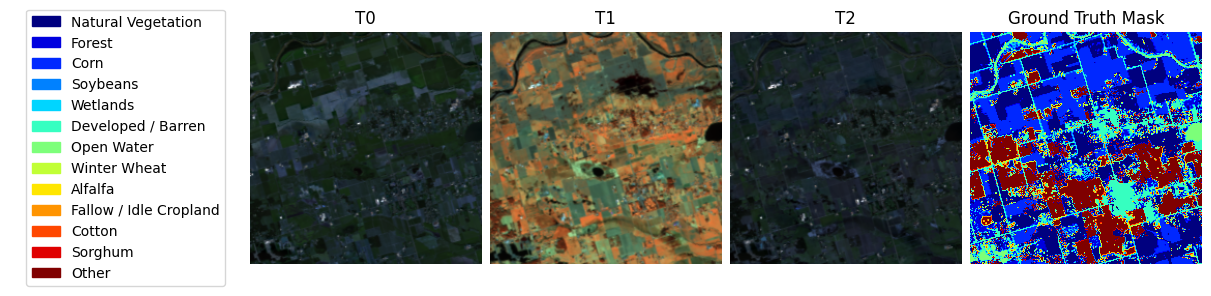

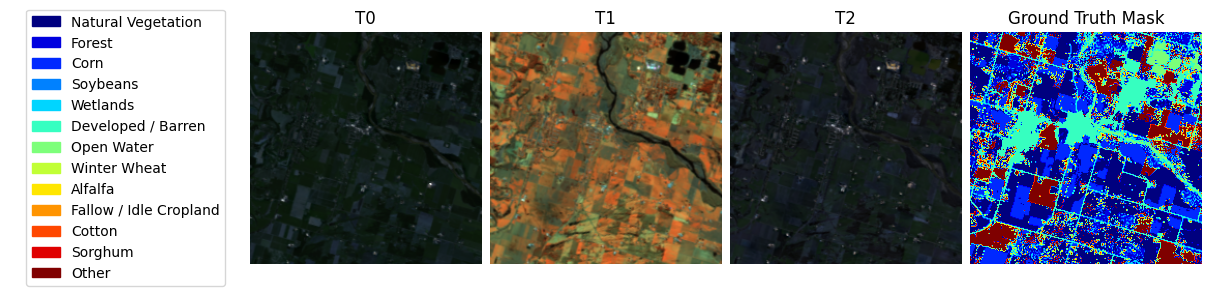

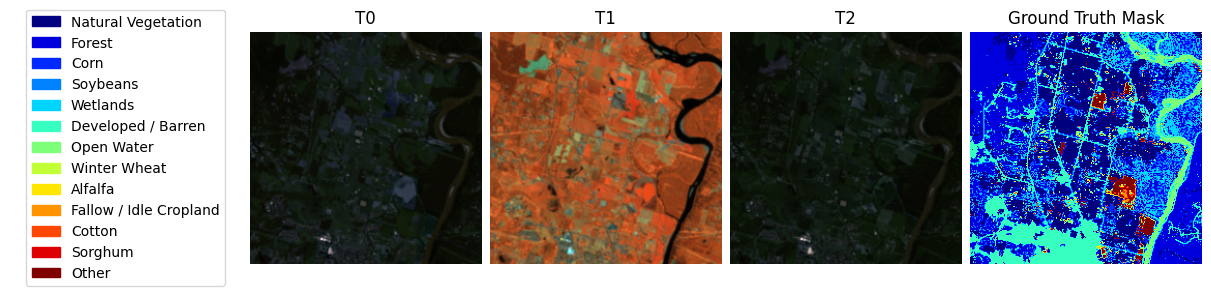

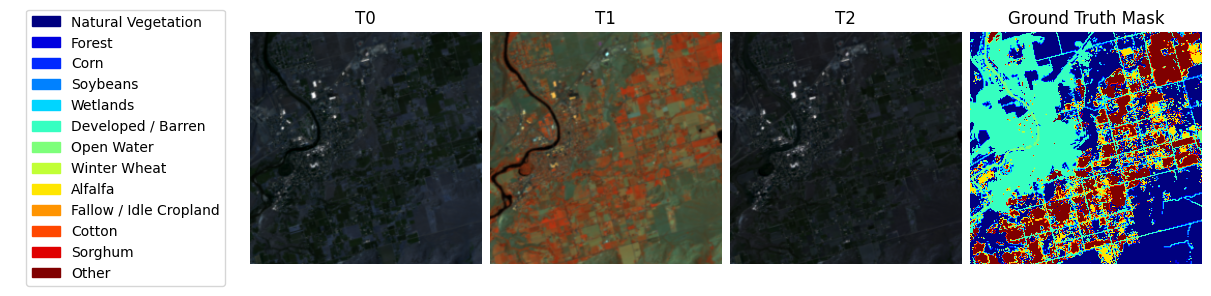

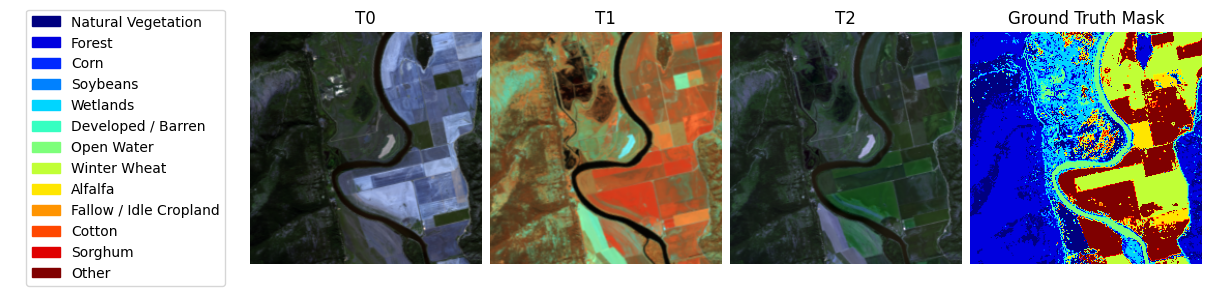

In [12]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [13]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

250

In [14]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

250

# Fine-tune Prithvi

In [18]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/multicrop/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=5,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/multicrop",
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300_tl", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 3,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    
)

Seed set to 0
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


In [16]:
%reload_ext tensorboard
%tensorboard --logdir output/multicrop

In [25]:
# Training
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  383 M │ eval │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ eval │
│ 2 │ train_metrics │ MetricCollection │      0 │ eval │
│ 3 │ val_metrics   │ MetricCollection │      0 │ eval │
│ 4 │ test_metrics  │ ModuleList       │      0 │ eval │
└───┴───────────────┴──────────────────┴────────┴──────┘

Trainable params: 79.9 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 383 M                                                                                                
Total estimated model params size (MB): 1.5 K                                                                      
Modules in train mode: 0                                                                                           
Modules in eval mode: 617

Output()

AssertionError: 

In [23]:
best_ckpt_path = "output/multicrop/checkpoints/best-epoch=00.ckpt"

In [21]:
def run_test_and_plot(ckpt_path):

    # calculate test metrics
    trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

    # get predictions
    preds = trainer.predict(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

    # get data 
    data_loader = trainer.predict_dataloaders
    batch = next(iter(data_loader))

    # plot
    BATCH_SIZE = 8
    for i in range(BATCH_SIZE):

        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[0][0][i].cpu().numpy()

        datamodule.predict_dataset.plot(sample)
        

In [24]:
run_test_and_plot(best_ckpt_path)

Restoring states from the checkpoint path at output/multicrop/checkpoints/best-epoch=00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at output/multicrop/checkpoints/best-epoch=00.ckpt


Output()

AssertionError: 

In [47]:
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

Restoring states from the checkpoint path at output/multicrop/checkpoints/best-epoch=01.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at output/multicrop/checkpoints/best-epoch=01.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.28732070326805115         │
│      test/Multiclass_F1_Score       │         0.28732070326805115         │
│    test/Multiclass_Jaccard_Index    │         0.14861992001533508         │
│ test/Multiclass_Jaccard_Index_Micro │          0.167760968208313          │
│              test/loss              │         2.1327478885650635          │
│      test/multiclassaccuracy_0      │          0.27217897772789           │
│      test/multiclassaccuracy_1      │         0.2900075614452362          │
│     test/multiclassaccuracy_10      │        0.0004904964007437229        │
│     test/multiclassaccuracy_11      │        0.003243264276534319         │
│     test/multiclassaccuracy_12      │         0.24703626334667206         │
│      test/multiclassaccuracy_2      │         0.09970597922801971         │
│      test/multiclassaccuracy_3      │         0.8402101993560791          │
│      test/multiclassaccuracy_4      │         0.5552170872688293          │
│      test/multiclassaccuracy_5      │         0.3204825818538666          │
│      test/multiclassaccuracy_6      │         0.6659072041511536          │
│      test/multiclassaccuracy_7      │         0.11591709405183792         │
│      test/multiclassaccuracy_8      │         0.03542913869023323         │
│      test/multiclassaccuracy_9      │       0.00041983614210039377        │
│    test/multiclassjaccardindex_0    │         0.22958993911743164         │
│    test/multiclassjaccardindex_1    │         0.21848531067371368         │
│   test/multiclassjaccardindex_10    │        0.0004743098106700927        │
│   test/multiclassjaccardindex_11    │        0.003193484153598547         │
│   test/multiclassjaccardindex_12    │         0.11702272295951843         │
│    test/multiclassjaccardindex_2    │         0.09150933474302292         │
│    test/multiclassjaccardindex_3    │         0.15660738945007324         │
│    test/multiclassjaccardindex_4    │         0.2980688214302063          │
│    test/multiclassjaccardindex_5    │         0.1861080676317215          │
│    test/multiclassjaccardindex_6    │         0.5165600180625916          │
│    test/multiclassjaccardindex_7    │         0.08545481413602829         │
│    test/multiclassjaccardindex_8    │         0.02856592647731304         │
│    test/multiclassjaccardindex_9    │       0.00041874177986755967        │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 2.1327478885650635,
  'test/Multiclass_Accuracy': 0.28732070326805115,
  'test/multiclassaccuracy_0': 0.27217897772789,
  'test/multiclassaccuracy_1': 0.2900075614452362,
  'test/multiclassaccuracy_2': 0.09970597922801971,
  'test/multiclassaccuracy_3': 0.8402101993560791,
  'test/multiclassaccuracy_4': 0.5552170872688293,
  'test/multiclassaccuracy_5': 0.3204825818538666,
  'test/multiclassaccuracy_6': 0.6659072041511536,
  'test/multiclassaccuracy_7': 0.11591709405183792,
  'test/multiclassaccuracy_8': 0.03542913869023323,
  'test/multiclassaccuracy_9': 0.00041983614210039377,
  'test/multiclassaccuracy_10': 0.0004904964007437229,
  'test/multiclassaccuracy_11': 0.003243264276534319,
  'test/multiclassaccuracy_12': 0.24703626334667206,
  'test/Multiclass_F1_Score': 0.28732070326805115,
  'test/Multiclass_Jaccard_Index': 0.14861992001533508,
  'test/multiclassjaccardindex_0': 0.22958993911743164,
  'test/multiclassjaccardindex_1': 0.21848531067371368,
  'test/multiclass

In [48]:
preds = trainer.predict(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

Restoring states from the checkpoint path at output/multicrop/checkpoints/best-epoch=01.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at output/multicrop/checkpoints/best-epoch=01.ckpt


Output()

In [49]:
data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

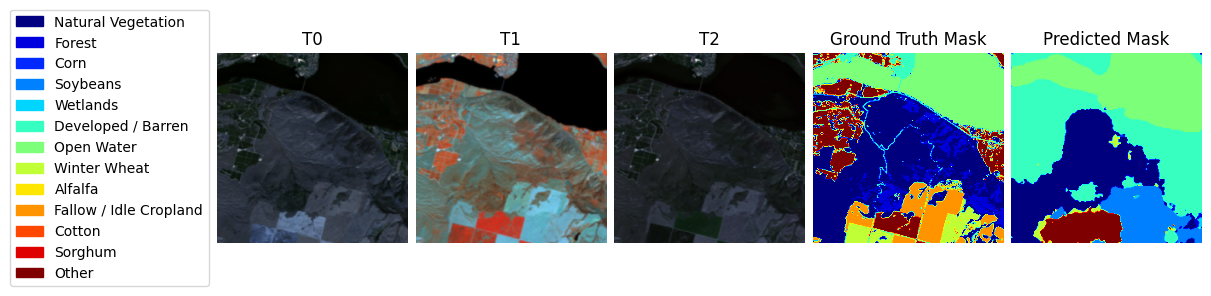

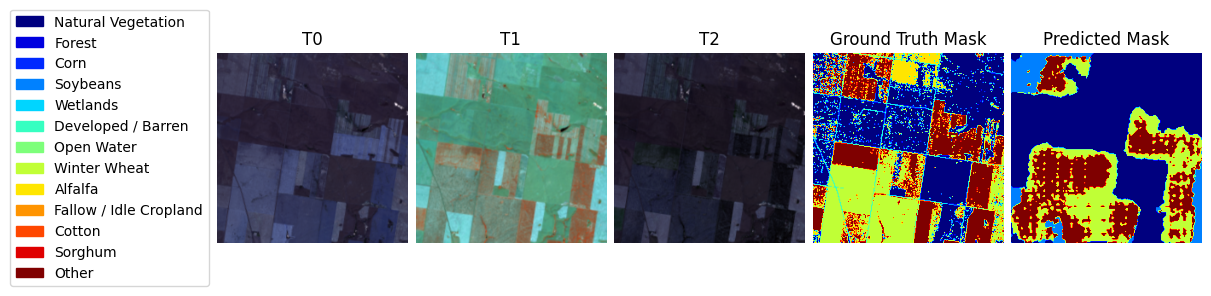

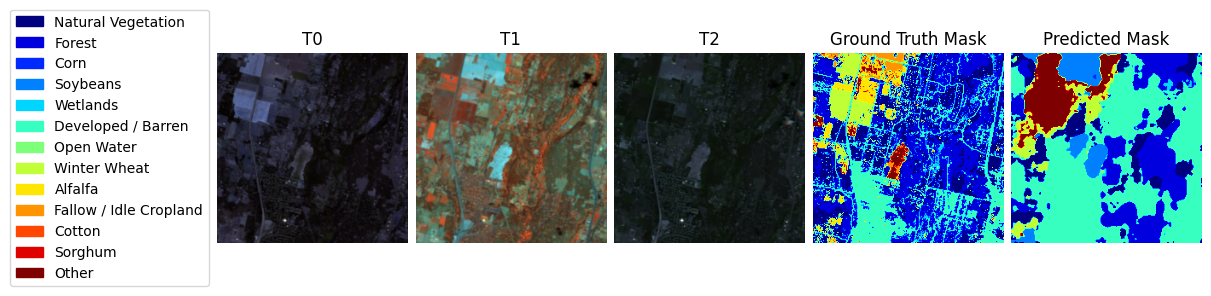

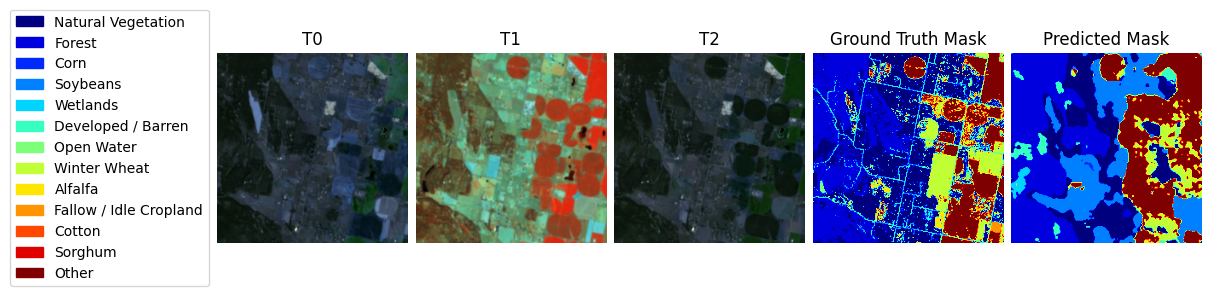

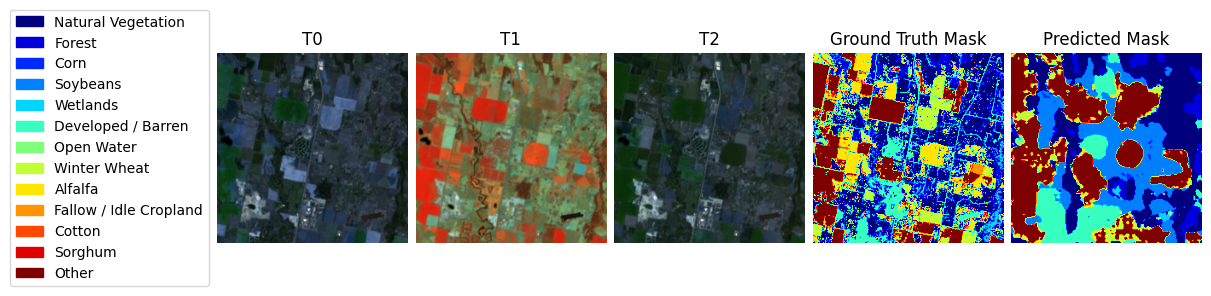

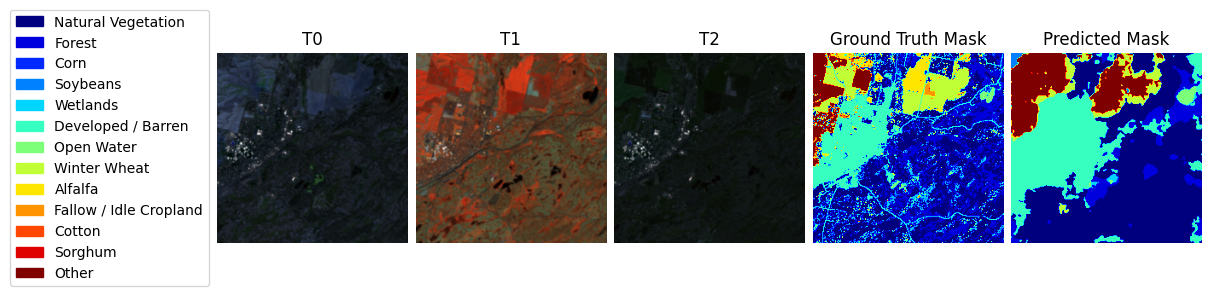

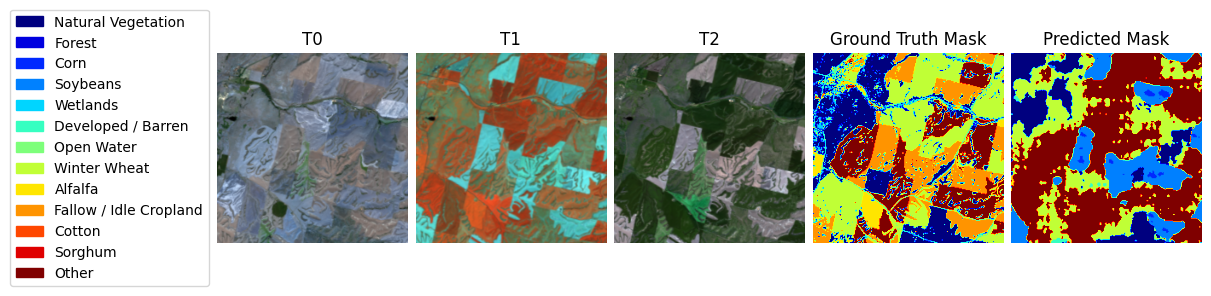

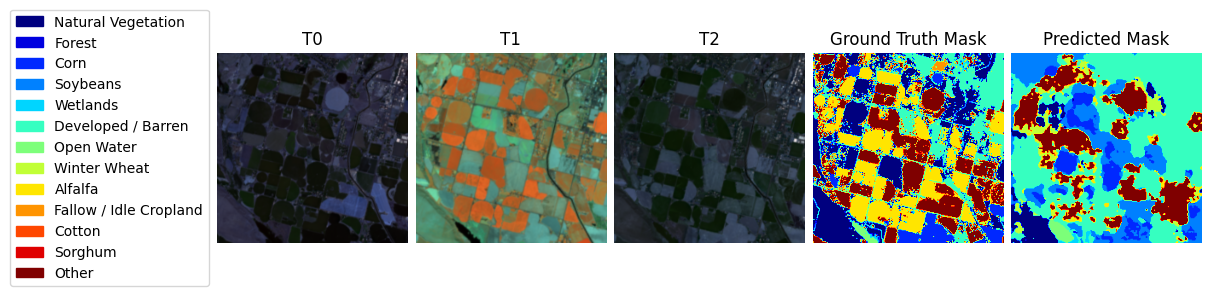

In [50]:
BATCH_SIZE = 8
for i in range(BATCH_SIZE):
    
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[0][0][i].cpu().numpy()
    
    datamodule.predict_dataset.plot(sample)

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [29]:
# Download config
!wget https://raw.githubusercontent.com/blumenstiel/TerraTorch-Examples/refs/heads/main/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml

--2025-03-14 16:49:57--  https://raw.githubusercontent.com/blumenstiel/TerraTorch-Examples/refs/heads/main/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1966 (1.9K) [text/plain]
Saving to: ‘prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml’

prithvi_v2_eo_300_t 100%[===================>]   1.92K  --.-KB/s    in 0s      

2025-03-14 16:49:58 (24.4 MB/s) - ‘prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml’ saved [1966/1966]



In [ ]:
# Run fine-tuning
!terratorch fit -c prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml